In the previous chapter on multilevel modeling, our adaptive priors allowed us to use data about one subgroup of the data to learn about other groups. However, that knowledge transfer was limited to parameters of the same type. Like in the chimpanzee example, all of our $\alpha_j$'s had one prior parametrized by $\bar{\alpha}$ and $\sigma_\alpha$, and all the $\gamma_j$'s were parametrized by a $\sigma_\gamma$. Learning something about $\alpha_1$ helped us learn a bit about $\alpha_2$, but nothing about $\gamma_2$. In real life, sometimes there are correlations between different types of variables that allow us to learn something about multiple types at the same time and squeeze more information from our data.

In [2]:
import sys, warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Path, PathPatch
import seaborn as sns
import scipy.stats as stats
from scipy import interpolate
import torch
tt =  torch.tensor
import pyro
from pyro import poutine
from pyro.distributions import (
    MultivariateNormal, Normal, LKJCorrCholesky, Exponential, Bernoulli, Poisson, HalfNormal
)
from pyro.infer import Predictive
from pyro.ops.stats import waic, hpdi
import arviz as az
import xarray as xr
import networkx as nx

from utils import traceplot, train_nuts, unnest_samples

torch.multiprocessing.set_sharing_strategy("file_system")
pyro.enable_validation()

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 27 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

scipy     : 1.12.0
arviz     : 0.17.1
matplotlib: 3.9.0
seaborn   : 0.12.2
numpy     : 1.26.4
xarray    : 2024.5.0
networkx  : 3.1
pyro      : 1.9.1
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
pandas    : 2.2.2
torch     : 2.3.0

Watermark: 2.4.3



### Code 14.36 - 14.45

Up until now, we have only looked at pooling groups of variables when the groups are discrete and unordered (groups of cafes, chimpanzees, tadpoles, households, etc). There is no sense in which cafe 1 comes before/after cafe 2, they are just labels. But what if we want to extend pooling to groups where the association is continuous? For example, we may have a dataset of people of various ages, and we want to pool across people with similar ages. If two people's ages are pretty close, they are probably more similar than people who are decades apart.

In order to do this, we'll have to make use of "Gaussian processes" (GP's), which basically promote the covariance matrix we've seen before to a covariance _function_, which allows calculating covariance between two continuously-indexed groups.

We will learn about GP's in the context of the Oceanic tool dataset we've seen before. Previously, we tried to take into account contact between societies with a binary variable. However, this doesn't take into account which societies interacted with each other (and possibly exchanged tools). We would expect that nearby societies probably had similar tool counts.

In [4]:
# get distance matrix between islands (units are thousands of kilometers)
dmatrix_df = pd.read_csv("data/islandsDistMatrix.csv").set_index("Unnamed: 0")
dmatrix_df.index.name = ""
dmatrix_df.head()

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
,,,,,,,,,,
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884


In [5]:
# get normal dataset
island_df = pd.read_csv("data/islands.csv", sep=";")
island_df.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


In [6]:
data = {
    "N": len(island_df),
    "dmatrix": tt(dmatrix_df.values).double(),
    "dmatrix2": tt(dmatrix_df.values**2).double(),
    "id": tt(island_df.index.values).long(),
    "tools": tt(island_df["total_tools"].values).double(),
    "population": tt(island_df["population"].values).double(),
}

We will use the theoretically motivated model from before (power-law relationship between tools and population), but modify it with a multiplicative factor to account for distance between islands.

$$\begin{align*}
T_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= e^{k_i} \alpha P_i^\beta/\gamma \\
\vec{k} &\sim \text{Normal}(\vec{0}, \boldsymbol{K}) \\
K_{ij} &= \eta^2 \exp(-\rho^2 D_{ij}^2) + \delta_{ij}\sigma^2 \\
\alpha,\beta,\gamma &\sim \text{Exponential}(1) \\
\eta^2 &\sim \text{Exponential}(2) \\
\rho^2 &\sim \text{Exponential}(0.5) \\
\sigma &= 0.01
\end{align*}$$

In [7]:
def model_m14_7(data, training=False):
    a = pyro.sample("α", Exponential(1.))
    b = pyro.sample("β", Exponential(1.))
    g = pyro.sample("γ", Exponential(1.))
    η2 = pyro.sample("η2", Exponential(2.))
    ρ2 = pyro.sample("ρ2", Exponential(0.5))
    σ = tt(0.01)
    K = (η2 * torch.exp(-ρ2*data["dmatrix2"]) + torch.eye(data["N"]) * σ).float()
    zeros = torch.zeros(data["N"]).float()
    k = pyro.sample("k", MultivariateNormal(zeros, covariance_matrix=K))
    λ = (k.exp() * a * torch.pow(data["population"], b)/g).double()
    if training:
        pyro.sample("T", Poisson(λ), obs=data["tools"])
    else:
        return pyro.sample("T", Poisson(λ))

In [8]:
m14_7 = train_nuts(model_m14_7, data, 500, 2000, jit_compile=True)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/2500 [00:00, ?it/s]/tmp/ipykernel_18318/3210213763.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  σ = tt(0.01)
Sample: 100%|██████████| 2500/2500 [03:02, 13.72it/s, step size=3.60e-02, acc. prob=0.933]


In [9]:
m14_7.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      k[0]     -0.16      0.29     -0.16     -0.67      0.28    436.68      1.00
      k[1]     -0.02      0.28     -0.02     -0.43      0.47    379.02      1.00
      k[2]     -0.07      0.26     -0.07     -0.49      0.34    367.15      1.00
      k[3]      0.35      0.25      0.34     -0.02      0.76    409.59      1.00
      k[4]      0.07      0.24      0.08     -0.32      0.47    430.51      1.00
      k[5]     -0.39      0.27     -0.37     -0.83      0.01    507.60      1.00
      k[6]      0.13      0.24      0.14     -0.26      0.49    436.59      1.00
      k[7]     -0.22      0.25     -0.20     -0.61      0.19    468.37      1.00
      k[8]      0.25      0.23      0.26     -0.11      0.61    422.49      1.00
      k[9]     -0.19      0.34     -0.16     -0.70      0.40    549.14      1.00
         α      1.46      1.09      1.17      0.02      2.97   1086.60      1.00
         β      0.28      0

Even though we sampled 2000 times, the number of effective samples is pretty low... Let's try a non-centered parametrization for the $k_i$:

In [10]:
def model_m14_7x(data, training=False):
    a = pyro.sample("α", Exponential(1.))
    b = pyro.sample("β", Exponential(1.))
    g = pyro.sample("γ", Exponential(1.))
    η2 = pyro.sample("η2", Exponential(2.))
    ρ2 = pyro.sample("ρ2", Exponential(0.5))
    σ = tt(0.01)
    K = (η2 * torch.exp(-ρ2*data["dmatrix2"]) + torch.eye(data["N"]) * σ).double()
    zeros = torch.zeros(data["N"]).float()
#     k = pyro.sample("k", MultivariateNormal(zeros, covariance_matrix=K))
    k = pyro.sample("k", MultivariateNormal(zeros, torch.eye(data["N"])))
    k = torch.linalg.cholesky(K) @ k.double()
    λ = (k.exp() * a * torch.pow(data["population"], b)/g).double()
    if training:
        pyro.sample("T", Poisson(λ), obs=data["tools"])
    else:
        return pyro.sample("T", Poisson(λ))

In [11]:
m14_7x = train_nuts(model_m14_7x, data, 500, 2000, jit_compile=True)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/2500 [00:00, ?it/s]/tmp/ipykernel_18318/49819017.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  σ = tt(0.01)
Sample: 100%|██████████| 2500/2500 [03:19, 12.54it/s, step size=2.63e-02, acc. prob=0.951]


In [12]:
m14_7x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      k[0]     -0.50      0.76     -0.50     -1.78      0.73    898.62      1.00
      k[1]      0.36      0.76      0.35     -0.78      1.71   1656.55      1.00
      k[2]     -0.22      0.78     -0.21     -1.52      1.04   2060.29      1.00
      k[3]      0.92      0.62      0.91     -0.07      1.95    908.13      1.00
      k[4]      0.35      0.65      0.32     -0.71      1.42    956.15      1.00
      k[5]     -1.10      0.67     -1.08     -2.18     -0.07   1351.86      1.00
      k[6]      0.31      0.57      0.29     -0.55      1.28   1174.40      1.00
      k[7]     -0.38      0.68     -0.38     -1.55      0.69   1265.14      1.00
      k[8]      0.75      0.63      0.74     -0.33      1.72   1359.56      1.00
      k[9]     -0.43      0.83     -0.41     -1.79      0.90    672.07      1.00
         α      1.44      1.10      1.18      0.08      2.88   1587.01      1.00
         β      0.27      0

Wow, that is a drastic improvement! The power of reparametrization is not to be understated! The results appear similar, except for the $k_i$'s, but that is because the samples recorded by the second model have not been adjusted by the correlation matrix. We can see what they'd look like after the transformation:

In [17]:
s = m14_7x.get_samples()
K = (
    s["η2"][:,None,None]
    * torch.exp(-s["ρ2"][:,None,None]*data["dmatrix2"][None,...])
    + torch.eye(data["N"])[None,...] * 0.01
)
k = torch.einsum("ijk,ik->ij", torch.linalg.cholesky(K), s["k"])
df = []
for i in range(k.shape[1]):
    q = pyro.ops.stats.quantile(k[:,i], [0.05, 0.95])
    df.append({
        "": f"k[{i}]",
        "mean": k[:,i].mean().item(),
        "std": k[:,i].std().item(),
        "median": k[:,i].median().item(),
        "5.0%": q[0].item(),
        "95.0%": q[1].item(),
    })
pd.DataFrame(df).set_index("")

,mean,std,median,5.0%,95.0%
,,,,,
k[0],-0.188047,0.320737,-0.188097,-0.705031,0.330198
k[1],-0.042426,0.300737,-0.041496,-0.511329,0.442810
k[2],-0.085789,0.296296,-0.076293,-0.569198,0.378046
k[3],0.337965,0.269350,0.333432,-0.068001,0.779216
k[4],0.062952,0.262007,0.060663,-0.352060,0.478790
k[5],-0.395348,0.277917,-0.389780,-0.859998,0.032010
k[6],0.130286,0.258401,0.123488,-0.272066,0.548105
k[7],-0.217122,0.265979,-0.212024,-0.647734,0.189635
k[8],0.253535,0.245371,0.241230,-0.117666,0.649617


There are differences, but not anything major. I think we can be a bit more confident that the non-centered model is correct (and if anything, more correct than the centered one).

Now we want to understand the results. Let us plot the function defined by the parameters of the covariance matrix. How does the covariance fall off as a function of distance?

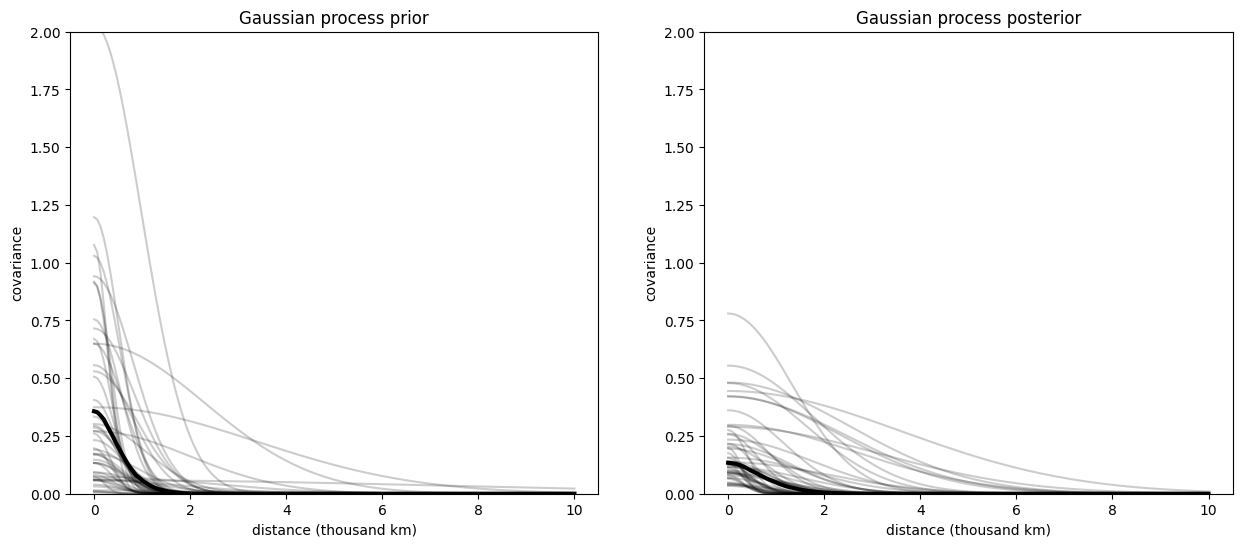

In [18]:
d = torch.linspace(0, 10, 150)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# plot prior
plt.sca(axes[0])
s = Predictive(model_m14_7x, {}, num_samples=1000)(data)
K = (
    s["η2"][:,None]
    * torch.exp(-s["ρ2"][:,None]*(d[None,:]**2))
)
idx = np.random.choice(1000, size=50)
for i in idx:
    plt.plot(d, K[i], color="black", alpha=0.2)
plt.plot(d, np.median(K, axis=0), color="black", linewidth=3)
plt.xlabel("distance (thousand km)")
plt.ylabel("covariance")
plt.ylim(bottom=0, top=2)
# plt.yscale("log")
plt.title("Gaussian process prior")
# plot posterior
plt.sca(axes[1])
s = m14_7x.get_samples()
K = (
    s["η2"][:,None]
    * torch.exp(-s["ρ2"][:,None]*(d[None,:]**2))
)
idx = np.random.choice(2000, size=50)
for i in idx:
    plt.plot(d, K[i], color="black", alpha=0.2)
plt.plot(d, np.median(K, axis=0), color="black", linewidth=3)
plt.xlabel("distance (thousand km)")
plt.ylabel("covariance")
plt.ylim(bottom=0, top=2)
# plt.yscale("log")
plt.title("Gaussian process posterior")
plt.show()

We can see that there is a good deal of uncertainty about the magnitude and suppression of the covariance (looks like long-tailed functions are not unlikely). Let's try and visualize this covariance in a geographic sense. I'll recreate the covariance matrix $\boldsymbol{K}$, then we can plot the connections on a crude map of the islands.

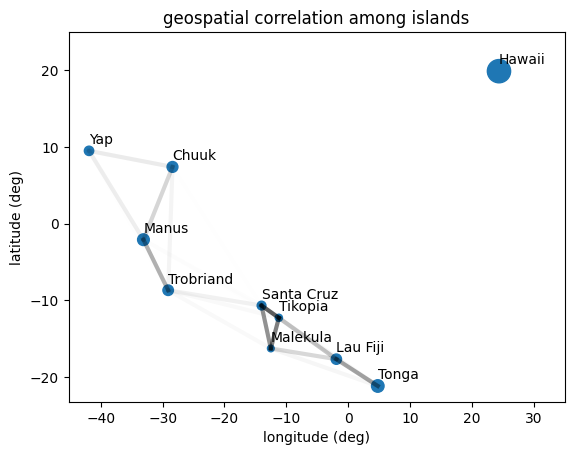

In [19]:
lon_lat = pd.read_csv("data/Kline2.csv", sep=";")[["lon2", "lat"]].values
s = m14_7x.get_samples()
K = np.median(
    s["η2"][:,None,None]
    * torch.exp(-s["ρ2"][:,None,None]*data["dmatrix2"][None,...])
    + torch.eye(data["N"])[None,...] * 0.01
, axis=0)
plt.scatter(*lon_lat.T, s=data["population"].pow(0.45))
for i in range(10):
    plt.annotate(island_df["culture"].iloc[i], lon_lat[i], (0, 5), textcoords="offset points")
for i in range(10):
    for j in range(i, 10):
        plt.plot(lon_lat[[i,j],0], lon_lat[[i,j],1], alpha=5*K[i,j].item(), color="black", linewidth=3)
plt.xlabel("longitude (deg)")
plt.ylabel("latitude (deg)")
plt.xlim(right=35)
plt.ylim(top=25)
plt.title("geospatial correlation among islands")
plt.show()

Let's do the same thing, but now on a plot of the log population vs. tool number.

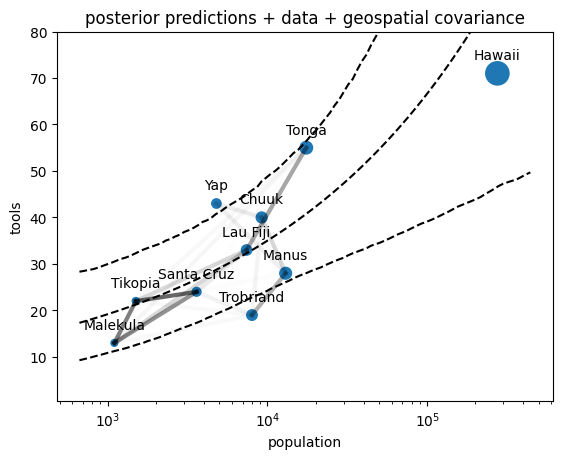

In [20]:
# plot posterior means/quantiles
P = torch.logspace(6.5, 13, steps=100, base=np.e)
λ = s["α"][:,None]*(P[None,:]**s["β"][:,None])/s["γ"][:,None]
q = pyro.ops.stats.quantile(λ, [0.05, 0.95], dim=0)
mu = λ.mean(dim=0)
plt.plot(P, mu, color="black", linestyle="--")
plt.plot(P, q[0], color="black", linestyle="--")
plt.plot(P, q[1], color="black", linestyle="--")
# plot data
P, T = [data[k] for k in ("population", "tools")]
plt.scatter(P, T, s=data["population"].pow(0.45))
for i in range(10):
    plt.annotate(island_df["culture"].iloc[i], (P[i], T[i]), (0, 10), textcoords="offset points", horizontalalignment="center")
for i in range(10):
    for j in range(i, 10):
        plt.plot(P[[i,j]], T[[i,j]], alpha=5*K[i,j].item(), color="black", linewidth=3)
plt.xscale("log")
plt.ylim(top=80)
plt.xlabel("population")
plt.ylabel("tools")
plt.title("posterior predictions + data + geospatial covariance")
plt.show()

We can see that the geospatial similarity between Malekula, Tikopia, and Santa Cruz can account for the fact that they all have similar, below-average numbers of tools. And despite Fiji being relatively close to those three, the effect of Tonga pulls it up. There are perhaps other causal factors influencing the covariance between these islands other than just the propensity for tools to be exchanged; perhaps the abundance of materials used to make the tools is similar amongst islands that are close by. The model does not have a causal explanation for why proximity is important, just that it is.

### Code 14.46 - 14.??

Another way of utilizing GP's is to take into account proximity in _time_ rather than distance. In the context of evolutionary biology, species that have come from a common ancestral split are more similar to each other the closer they are to that split. Biologists can utilize a "pylogenetic regression" that takes this into account.

In [46]:
# load dataset of traits
phylo_df = pd.read_csv("data/Primates301.csv", sep=";")
phylo_df.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [48]:
# load phylogenetic distance matrix
dmatrix_df = pd.read_csv("data/Primates301_distance_matrix.csv", sep=";")
dmatrix_df.index.name = ""
dmatrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
,,,,,,,,,,,,,,,,,,,,,
0,0.000000,23.789805,23.789805,23.789804,23.789804,23.789806,23.789806,23.789806,23.789804,23.789805,...,146.006037,146.006037,146.006036,146.006036,146.006037,146.006037,137.680065,137.680065,137.680065,137.680065
1,23.789805,0.000000,12.858418,15.780435,15.780435,12.858419,12.858419,12.858419,15.780435,12.858418,...,146.006038,146.006038,146.006037,146.006037,146.006038,146.006038,137.680066,137.680066,137.680066,137.680066
2,23.789805,12.858418,0.000000,15.780435,15.780435,4.037887,4.037887,4.037887,15.780435,5.463272,...,146.006038,146.006038,146.006037,146.006037,146.006038,146.006038,137.680066,137.680066,137.680066,137.680066
3,23.789804,15.780435,15.780435,0.000000,0.548556,15.780436,15.780436,15.780436,11.974562,15.780435,...,146.006037,146.006037,146.006036,146.006036,146.006037,146.006037,137.680065,137.680065,137.680065,137.680065
4,23.789804,15.780435,15.780435,0.548556,0.000000,15.780436,15.780436,15.780436,11.974562,15.780435,...,146.006037,146.006037,146.006036,146.006036,146.006037,146.006037,137.680065,137.680065,137.680065,137.680065


First, we will imagine trying to figure out whether "group size" (the typical size of a species' social group) influences brain size. Perhaps having a bigger brain helps to manage all the social intricacies required of group living. This implies the following causal time series:

In [29]:
G = nx.DiGraph()
G.add_nodes_from([
    (1, dict(label=r"$U_{t-1}$", pos=(0, 0), color="#cccccc")),
    (2, dict(label=r"$B_{t-1}$", pos=(0, 0.5), color="#cccccc")),
    (3, dict(label=r"$G_{t-1}$", pos=(0, 1), color="#cccccc")),
    (4, dict(label=r"$G_{t}$", pos=(1, 1), color="white")),
    (5, dict(label=r"$B_{t}$", pos=(1, 0.5), color="white")),
    (6, dict(label=r"$U_{t}$", pos=(1, 0), color="#cccccc")),
])
G.add_edges_from([(1,6), (1,5), (1,4), (2,5), (3,4)])
G.add_edge(3, 5, color="red")

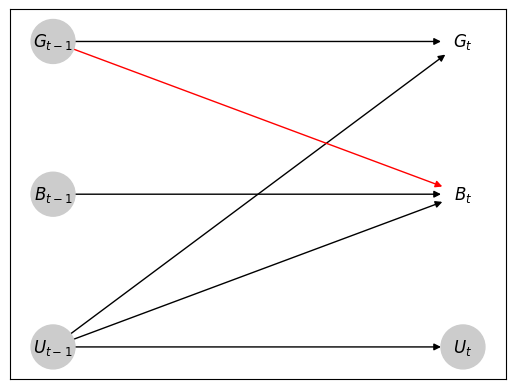

In [30]:
ncol = nx.get_node_attributes(G, "color").values()
ecol = [G.edges[e].get("color", "black") for e in G.edges]
pos = nx.get_node_attributes(G, "pos")
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx(G, pos, labels=labels, node_color=ncol, edge_color=ecol, node_size=1000)
plt.show()

The grey nodes are unobserved factors (mostly attributes from the past/previous timestep), and the red edge is the relationship of interest - "does group size influence brain size?". We haven't observed any of the species attributes in the past, so how do we disentangle the effect of multiple influences on $B_t$?

Well, this graph only assumes a single species is at play. If we have multiple species in our dataset that have common ancestors, then we can pool across species to help estimate the unobserved factors in the past. And the closer those species are to the common ancestor, the more they will influence the pooling. This is the main thrust of the idea.

Let's re-draw our causal graph, taking the phylogenetic ancestry ($P$) into account

In [31]:
G = nx.DiGraph()
G.add_nodes_from([
    ("U", dict(pos=(0.5, 0), color="#cccccc")),
    ("P", dict(pos=(1, 0))),
    ("M", dict(pos=(0.5, 0.5))),
    ("G", dict(pos=(0, 1))),
    ("B", dict(pos=(1, 1)))
])
G.add_edges_from([("P", "U"), ("U", "G"), ("U", "M"), ("U", "B"), ("M", "G"), ("M", "B")])
G.add_edge("G", "B", color="red")

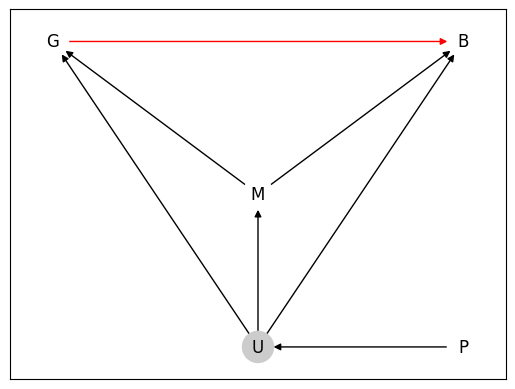

In [32]:
ncol = [G.nodes[n].get("color", "white") for n in G.nodes]
ecol = [G.edges[e].get("color", "black") for e in G.edges]
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx(G, pos, edge_color=ecol, node_color=ncol, node_size=500)
plt.show()

We know for a fact that one of the confounders of this relationship between $G$ and $B$ is the body mass $M$, which could potentially influence both. We can close off this backdoor by conditioning on $M$. There is also unfortunately a backdoor through $U$ which we cannot condition on. However, the phylogenetic ancestry factors $P$ can be used to help disentangle its influence, by taking into account the covariation of $B$ among many different species. This implies a model of the form

$$\begin{align*}
\vec{B} &\sim \text{Normal}(\vec{\mu}, \boldsymbol{S}) \\
\mu_i &= \alpha + \beta_G G_i + \beta_M M_i
\end{align*}$$
In an ordinary regression, the covariance matrix $\boldsymbol{S}$ is simply proportional to the identity matrix $\boldsymbol{S} = \sigma^2 \boldsymbol{I}$, but this doesn't take into account any of the phylogenetic distances. Let's pretend this is true for now and see what happens.

In [33]:
phylo_df.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [34]:
def standardize(x):
    x = x.log()
    return (x - x.mean())/x.std()

df = phylo_df[["group_size", "body", "brain"]].copy()
df = df[~df.isna().any(axis=1)]

data = {
    "N": len(df),
    "group": standardize(tt(df["group_size"].values).double()),
    "mass": standardize(tt(df["body"].values).double()),
    "brain": standardize(tt(df["brain"].values).double()),
    "I": torch.eye(len(df)).double(),
}

In [35]:
def model_m14_8(data, training=False):
    a = pyro.sample("α", Normal(0., 1.))
    bG = pyro.sample("βG", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    sigma2 = pyro.sample("σ2", Exponential(1.))
    S = sigma2 * data["I"]
    mu = a + bM * data["mass"] + bG * data["group"]
    if training:
        pyro.sample("B", MultivariateNormal(mu, S), obs=data["brain"])
    else:
        return pyro.sample("B", MultivariateNormal(mu, S))

In [36]:
m14_8 = train_nuts(model_m14_8, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:14, 166.79it/s, step size=5.78e-01, acc. prob=0.904]


In [37]:
m14_8.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      0.00      0.02      0.00     -0.03      0.03   1906.82      1.00
        βG      0.12      0.02      0.12      0.09      0.16   1825.66      1.00
        βM      0.89      0.02      0.89      0.86      0.93   1614.92      1.00
        σ2      0.05      0.01      0.05      0.04      0.06   1562.86      1.00

Number of divergences: 0


Looks like a reliable positive association between group size and brain size then. But we know that there are confounding factors that we aren't taking into account... we need to use the phylogenetic distance to help disentangle them. The original way to take this into account is to treat evolutionary drift as a diffusion process, goverened by _Brownian motion_ (in physics, this is the model by which simple kinetic diffusion occurs in a gas). The mathematical basis of this is called a [_Wiener process_](https://en.wikipedia.org/wiki/Wiener_process). For a Weiner process, the covariance between two points separated in time is simply the time since the earlier of those two times $\text{cov}(W_s, W_t) = \min(s, t)$, and their correlation is $\text{corr}(W_s, W_t) = \sqrt{s/t}$ ($t\ge s$). However, the covariance matrix for $B$ that we're using in our model isn't the same thing as the Weiner process covariance, but is actually a monotonically decreasing _linear_ transformation:

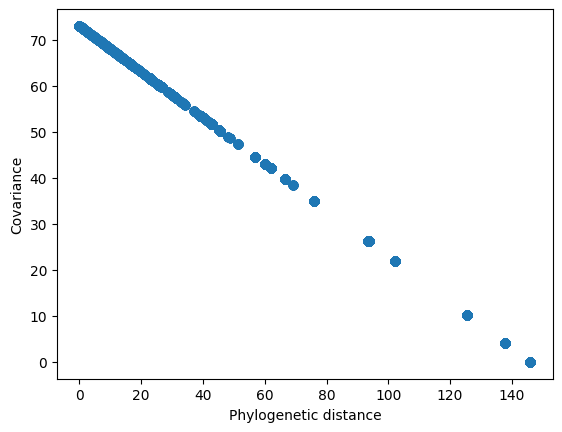

In [38]:
V = pd.read_csv("data/Primates301_vcov_matrix.csv").set_index("Unnamed: 0")
V.index.name = ""
plt.scatter(dmatrix_df.values.flatten(), V.values.flatten())
plt.xlabel("Phylogenetic distance")
plt.ylabel("Covariance")
plt.show()

We can confirm that this is indeed the transformation used:

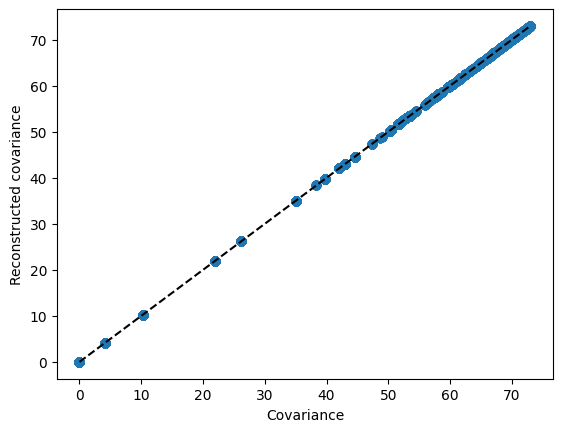

In [39]:
_V = dmatrix_df.values
_V = V.values.max() - (V.values.max()/_V.max()) * _V
plt.scatter(V.values.flatten(), _V.flatten())
x = np.linspace(0, V.values.max())
plt.plot(x, x, color="black", linestyle="--")
plt.xlabel("Covariance")
plt.ylabel("Reconstructed covariance")
plt.show()

In [45]:
df = phylo_df.set_index("name")[["group_size", "body", "brain"]].copy()
mask = ~df.isna().any(axis=1)
df = df[mask]
mask = mask[mask]
_V = V.loc[mask.index, mask.index].values

data = {
    "N": len(df),
    "group": standardize(tt(df["group_size"].values).double()),
    "mass": standardize(tt(df["body"].values).double()),
    "brain": standardize(tt(df["brain"].values).double()),
    "R": tt(_V/_V.max()).double(),
}

In [41]:
def model_m14_9(data, training=False):
    a = pyro.sample("α", Normal(0., 1.))
    bG = pyro.sample("βG", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    sigma2 = pyro.sample("σ2", Exponential(1.))
    S = sigma2 * data["R"]
    mu = a + bM * data["mass"] + bG * data["group"]
    if training:
        pyro.sample("B", MultivariateNormal(mu, S), obs=data["brain"])
    else:
        return pyro.sample("B", MultivariateNormal(mu, S))

In [42]:
m14_9 = train_nuts(model_m14_9, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:14, 173.82it/s, step size=6.89e-01, acc. prob=0.926]


In [43]:
m14_9.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α     -0.19      0.17     -0.19     -0.47      0.09   1740.30      1.00
        βG     -0.01      0.02     -0.01     -0.04      0.02   2260.60      1.00
        βM      0.70      0.04      0.70      0.64      0.76   1992.47      1.00
        σ2      0.16      0.02      0.16      0.13      0.19   2058.37      1.00

Number of divergences: 0


The inclusion of this covariance matrix has now completely eliminated the relationship between group size and brain size! The interpretation of this result is that there is likely a lot of clustering of brain size in the family tree, and this introduces a spurious correlation with group size, which also clusters in the tree. Providing the correlation matrix allows the model to take this clustering into account.

The Weiner process is kind of restrictive, in that it completely specifies the correlation beforehand, and only allows tuning of the magnitude of the covariance (at least the way that we have parametrized it). The covariance falls off very slowly with distance, and in kind of an arbitrary way. It might be better to use a _Ornstein-Uhlenbeck process_ (in physics, this describes the kinetic drift of a particle under friction), which is damped Brownian motion that returns towards the mean. The OU process defines the covariance as the exponential attenuation of the linear distance:

$$
K_{ij} = \eta^2 \exp\left(-\rho^2 D_{ij}\right) + \delta_{ij} \sigma
$$

In [44]:
df = phylo_df.set_index("name")[["group_size", "body", "brain"]].copy()
mask = ~df.isna().any(axis=1)
df = df[mask]
mask = mask[mask]
D = dmatrix_df.loc[mask.index, mask.index].values

data = {
    "N": len(df),
    "group": standardize(tt(df["group_size"].values).double()),
    "mass": standardize(tt(df["body"].values).double()),
    "brain": standardize(tt(df["brain"].values).double()),
    "D": tt(D/D.max()).double(),
}

KeyError: "None of [Index(['Allenopithecus_nigroviridis', 'Alouatta_belzebul', 'Alouatta_caraya',\n       'Alouatta_guariba', 'Alouatta_palliata', 'Alouatta_pigra',\n       'Alouatta_seniculus', 'Aotus_azarai', 'Aotus_trivirgatus',\n       'Arctocebus_calabarensis',\n       ...\n       'Tarsius_syrichta', 'Theropithecus_gelada', 'Trachypithecus_cristatus',\n       'Trachypithecus_geei', 'Trachypithecus_johnii',\n       'Trachypithecus_obscurus', 'Trachypithecus_phayrei',\n       'Trachypithecus_pileatus', 'Trachypithecus_vetulus',\n       'Varecia_variegata_variegata'],\n      dtype='object', name='name', length=151)] are in the [index]"

In [254]:
def model_m14_10(data, training=False):
    a = pyro.sample("α", Normal(0., 1.))
    bG = pyro.sample("βG", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    eta2 = pyro.sample("η2", Exponential(1.))
    rho2 = pyro.sample("ρ2", Normal(3., 0.5)).abs()
    mu = a + bM * data["mass"] + bG * data["group"]
    K = eta2 * torch.exp(-rho2 * data["D"]) + 0.01*torch.eye(data["N"])
    if training:
        pyro.sample("B", MultivariateNormal(mu, K), obs=data["brain"])
    else:
        return pyro.sample("B", MultivariateNormal(mu, K))

In [ ]:
m14_10 = train_nuts(model_m14_10, data, 500, 2000)

In [ ]:
m14_10.summary()

Now the group size appears to be associated with brain size again (although the effect is very small). Why is this the case? Well the covariance implied by the OU process must be pretty different than that implied by the Weiner process (duh). My hypothesis is that since the vast majority of species in the tree are _not_ related to each other, the Weiner covariance needs to be suppressed greatly (hence the small value of $\sigma^2$) to match take this into account, but it also ends up suppressing the correlation between species that _are_ related. The OU kernel is much more flexible (has two free parameters instead of one), and also falls off with increasing distance much faster (just look at the plots above and you'll see the Weiner kernel falls off _very_ slowly). Looking below you'll see the behavior of the OU kernel:

In [ ]:
d = torch.linspace(0, 1, 100)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# plot prior function
plt.sca(axes[0])
s = Predictive(model_m14_10, {}, num_samples=1000)(data)
K = s["η2"][:,None].abs() * torch.exp(-s["ρ2"].abs()[:,None]*d[None,:])
mu_K = K.mean(dim=0)
q = pyro.ops.stats.quantile(K, [0.05, 0.95], dim=0)
plt.plot(d, mu_K, color="black")
plt.fill_between(d, *q, color="black", alpha=0.4, label="prior")
# plot posterior function
s = m14_10.get_samples()
K = s["η2"][:,None].abs() * torch.exp(-s["ρ2"].abs()[:,None]*d[None,:])
mu_K = K.mean(dim=0)
q = pyro.ops.stats.quantile(K, [0.05, 0.95], dim=0)
plt.plot(d, mu_K, color="C0")
plt.fill_between(d, *q, color="C0", alpha=0.4, label="posterior")
plt.axhline(0, color="black", linestyle="--")
plt.ylim(top=1.5)
plt.xlabel("Phylogenic distance (norm)")
plt.ylabel("Covariance")
plt.title("Comparison of Ornstein-Uhlenbeck prior/posterior kernels")
plt.legend()
# plot zoom-in of posterior
plt.sca(axes[1])
plt.plot(d, mu_K, color="C0")
plt.fill_between(d, *q, color="C0", alpha=0.4, label="posterior")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Phylogenic distance (norm)")
plt.ylabel("Covariance")
plt.title("Zoom-in of OU posterior")
plt.legend()
plt.show()

I'm curious why we chose a prior that is so different from the posterior... is this just to illustrate that we have so much data that the prior is irrelevant, or was it just a bad choice? Either way, the posterior seems to suggest that even at large phylogenic distances (i.e. $D/\max(D) \sim 1$), there is still a small, but nonzero amount of correlation. With the Weiner kernel, the covariance falls to zero at this point.